In [4]:
from astropy.io import fits as pyfits
from win32com.client import Dispatch
import numpy as np
from astropy import units as u
from astropy.coordinates import Angle
import matplotlib.pyplot as plt

# Built-in Python imports
import atexit
import logging
import math
import os
import shutil
import signal
import sys
import time

In [17]:
# Connect to spectrometer camera (may change to native ASI driver later for better support of additional functions
# such as gain/offset control). This is done via the ASCOM driver.

# Connect to the camera
camera = Dispatch('ASCOM.Simulator.Camera')
# Open settings dialog
camera.SetupDialog()
camera.Connected = True

# Set the exposure time
camera.StartExposure(1, True)

# Wait for the exposure to complete
while camera.ImageReady == False:
    time.sleep(0.1)

# Get the image data
image = camera.ImageArray

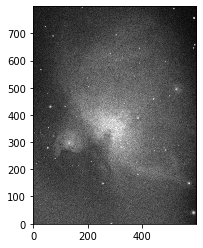

In [18]:
# Display the image
plt.imshow(image, cmap='gray', interpolation='nearest', origin='lower')
plt.show()

In [20]:
# Change image data type to 16-bit unsigned integer (required by FITS standard)
# and convert to numpy array
image = np.array(image, dtype=np.uint16)
# Save image to file
image_file_path_tmp = os.path.join(os.getcwd(), 'testfits.tmp')
image_file_path_final = os.path.join(os.getcwd(), 'testfits.fits')
pyfits.writeto(image_file_path_tmp, image, overwrite=True)

# Add FITS header information
hdulist = pyfits.open(image_file_path_tmp, mode="update")
header = hdulist[0].header
header.set("SPECID", 'MS260i', "Spectrometer ID")
header.set("SPECPOS", 656.3, "Spectrometer position (nm)")
header.set("GRATING", 3, "Grating number")
header.set("GRATLINE", 1200, "Grating lines/mm")
header.set("GRATBLAZ", 30, "Grating blaze angle (deg)")
header.set("GRATWAVE", 500, "Grating wavelength (nm)")

hdulist.flush()
hdulist.close()

# Move modified FITS file into final location, replacing any file
# that may already be there. By writing to another file and then
# renaming it at the last second, we make sure that other processed
# (like the file transfer daemon) don't see incomplete, partially-written
# files
#remove_file_if_needed(image_file_path_final)
os.rename(image_file_path_tmp, image_file_path_final)
#logging.info("Final file saved to %s", image_file_path_final)